In [118]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = Path("data")
PROCESSED_DATA = DATA_ROOT / "processed"

trends = pd.read_csv(PROCESSED_DATA / "trends.csv", index_col=0, parse_dates=True)
prices = pd.read_csv(PROCESSED_DATA / "prices.csv", index_col=0, parse_dates=True)
volumes = pd.read_csv(PROCESSED_DATA / "volumes.csv", index_col=0, parse_dates=True)

trends.shape, prices.shape, volumes.shape

((1781, 1574), (1781, 92), (1781, 92))

In [3]:
def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    # return (df - df.min()) / (df.max() - df.min())
    return df/df.sum(axis=0)

trends = normalize_df(trends)
prices = normalize_df(prices)
volumes = normalize_df(volumes)

unified = pd.concat([trends, volumes], axis=1).T
unified.shape

(1666, 1781)

In [4]:
import json

with open('cfg/stock_data.json') as f:
    stock_data = json.load(f)['entries']
    
with open('cfg/stock_data_clustering.json') as f:
    stock_data_clustering = json.load(f)['entries']

In [5]:
stock_data =stock_data+stock_data_clustering

In [75]:
stock_df = pd.DataFrame(stock_data)
stock_df = stock_df.drop(columns=['start', 'end','aggregate','interval','period'])
stock_df['tickers'] = stock_df.apply(lambda x: [x['ticker']] if isinstance(x['ticker'], str) else x['tickers'], axis=1)
stock_df = stock_df.drop(columns=['ticker'])
stock_df = stock_df.drop_duplicates(subset=['tickers'])
stock_df['num_tickers'] = stock_df['tickers'].apply(len)
stock_df['is_sector'] = stock_df['name'].str.contains('US_')
stock_df.sort_values(by='num_tickers', ascending=False)
stock_df = stock_df[stock_df['name'].isin(prices.columns)]

single_stocks = stock_df.query('not is_sector and num_tickers==1')
is_etf = single_stocks['description'].str.lower().str.contains('etf|index|tracks')

stock_df['is_etf'] = False
stock_df.loc[is_etf.index, 'is_etf'] = is_etf

In [76]:
stock_df[stock_df['is_sector']]['tickers'].tolist()

[['XLK'],
 ['XLV'],
 ['XLF'],
 ['XLY'],
 ['XLP'],
 ['XLI'],
 ['XLE'],
 ['XLU'],
 ['XLB'],
 ['XLC'],
 ['XLRE'],
 ['IBB'],
 ['KBE'],
 ['KRE'],
 ['IYT'],
 ['ITB']]

In [91]:
stock_df[stock_df['is_etf']].tickers.apply(lambda x: x[0]).tolist()

['^GSPC',
 'ICLN',
 'TAN',
 'PHO',
 'EIS',
 'ISRA',
 'FRDM',
 'RSX',
 'ERUS',
 'SHE',
 'SPY',
 'QQQ',
 'IWM',
 'DIA']

In [92]:
holdings = pd.read_csv('etf_holdings_top50.csv')
holdings = holdings.groupby('ETF').agg(list)

tickers = stock_df.query('not is_sector and num_tickers==1').tickers.apply(lambda x:x[0]).to_list()
holdings['data_tickers'] = holdings['Ticker'].apply(lambda x: set(x).intersection(tickers))
holdings['num_data_tickers'] = holdings['data_tickers'].apply(len)
coloring = holdings[holdings['num_data_tickers']>1].drop(columns=['Ticker'])

In [93]:
coloring

,data_tickers,num_data_tickers
ETF,,
DIA,"{UNH, NVDA, CVX, JPM, GS, JNJ, AMZN, CRM, MSFT...",11
QQQ,"{NVDA, META, COST, TSLA, GOOGL, AVGO, ISRG, AM...",13
SHE,"{NVDA, MSFT, CVX, COST, JPM, LLY, JNJ, AMD, NO...",12
SPY,"{NVDA, META, COST, ORCL, JPM, LLY, TSLA, GOOGL...",17
XLC,"{META, GOOGL, NFLX}",3
XLE,"{SLB, XOM, COP, CVX}",4
XLF,"{BLK, JPM, MS, GS, BAC, MA, V}",7
XLK,"{NVDA, AVGO, CRWD, AMD, NOW, CRM, IBM, MSFT, P...",10
XLV,"{TMO, LLY, MRK, JNJ, ISRG, SYK, DHR, UNH, REGN}",9


/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



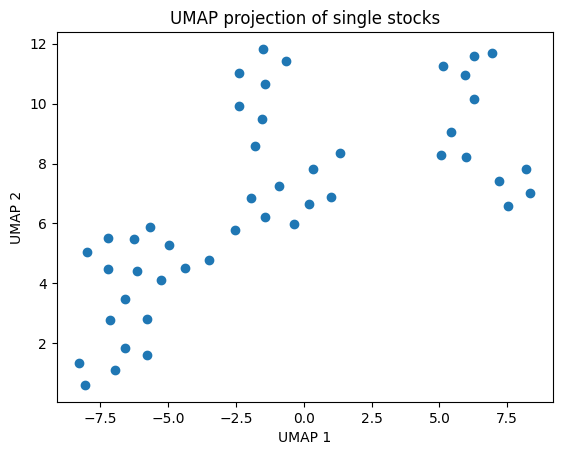

In [126]:
single_stocks = stock_df.query('not is_sector and num_tickers==1 and not is_etf')

# use UMAP to reduce dimensionality of single stocks
reducer = umap.UMAP(n_neighbors=3, min_dist=0.9, random_state=42)
# reducer = 
reduced_single_stocks = reducer.fit_transform(prices[single_stocks['name']].T)


plt.scatter(reduced_single_stocks[:, 0], reduced_single_stocks[:, 1])
plt.title('UMAP projection of single stocks')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [127]:
# plot the reduced stocks with coloring according to the first row of coloring

# plot using Plotly for the first ETF in `coloring`
for idx in range(len(coloring)):
    etf_name = coloring.index[idx]
    members = set(coloring.iloc[idx, 0])

    # build a series of "In ETF" / "Not in ETF"
    membership = single_stocks['tickers'].apply(lambda x: 'In' if x[0] in members else 'Not in')

    fig = px.scatter(
        x=reduced_single_stocks[:, 0],
        y=reduced_single_stocks[:, 1],
        color=membership,
        hover_name=single_stocks['name'].apply(lambda x: x[0]),
        title=f"PCA projection colored by presence in {etf_name}",
        labels={'color': 'Membership'},
        width=600,
        height=600
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()

In [37]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=0)
X_embedded = reducer.fit_transform(unified)

dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(X_embedded)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



-1     1071
 0       11
 1       22
 2        8
 3        7
       ... 
 92       5
 93       5
 94      30
 95      14
 96       5
Length: 98, dtype: int64

In [38]:
mask = labels != -1

fig = px.scatter(
    x=X_embedded[mask, 0],
    y=X_embedded[mask, 1],
    color=labels[mask].astype(str),
    hover_name=[unified.index[i] for i in np.where(mask)[0]],
    title="Soft-DTW Time Series Clustering (UMAP visualization)",
    width=600,
    height=600
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

In [39]:
# map labels to original indices in unified
label_map = {unified.index[i]: labels[i] for i in range(len(labels))}
label_series = pd.Series(label_map)
label_series = label_series[label_series != -1]  # remove outliers
label_series.sort_values().to_csv(PROCESSED_DATA / "cluster_labels.csv", header=["cluster"])

In [40]:
# make a json with cluster to list of items
cluster_map = {}
for idx, cluster in label_series.items():
    if cluster not in cluster_map:
        cluster_map[cluster] = []
    cluster_map[cluster].append(idx)
import json
with open(PROCESSED_DATA / "clusters.json", "w") as f:
    json.dump(cluster_map, f, indent=4)
    

In [41]:
with open(PROCESSED_DATA / 'cluster_GPT.json') as f:
    gpt_clusters = json.load(f)


In [50]:
clusters = list(gpt_clusters.keys())
from typing import Dict, Optional
from dataclasses import dataclass

@dataclass
class ClusterInfo:
    name: str
    description: str
    scores: Dict[str, float]
    coherence: float


cluster_infos = []
for cluster in clusters:
    info = gpt_clusters[cluster]
    cluster_infos.append(ClusterInfo(
        name=cluster,
        description=info["description"],
        scores=info["scores"],
        coherence=info["coherence"]
    ))

Text(0.5, 0, 'Coherence Score')

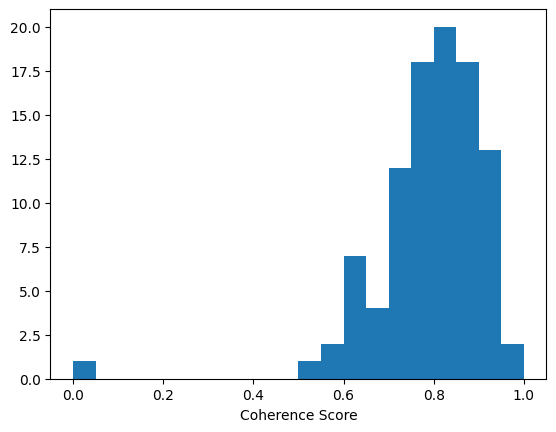

In [ ]:
coherence_scores = [info.coherence for info in cluster_infos]
import matplotlib.pyplot as plt
plt.hist(coherence_scores, bins=20)
plt.xlabel("Coherence Score")
c

In [53]:
prices

,ISRG,RSX,US_Transportation,Russell2000,US_Biotech,Google,V,US_Consumer_Staples,US_Consumer_Discretionary,BAC,...,MA,SLB,AAPL,HydrogenCCS,SAP,ASML,JNJ,CRM,CleanWater,BLK
date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,0.000398,0.000957,0.000435,0.000413,0.000524,0.000332,0.000455,0.000462,0.000460,0.000378,...,0.000456,0.000252,0.000384,0.000382,0.000529,0.000292,0.000483,0.000598,0.000439,0.000376
2020-09-06,0.000393,0.000948,0.000434,0.000411,0.000522,0.000329,0.000452,0.000459,0.000459,0.000374,...,0.000454,0.000249,0.000377,0.000381,0.000525,0.000288,0.000482,0.000590,0.000437,0.000374
2020-09-07,0.000387,0.000940,0.000432,0.000409,0.000519,0.000326,0.000450,0.000457,0.000457,0.000370,...,0.000453,0.000246,0.000371,0.000380,0.000521,0.000284,0.000481,0.000582,0.000435,0.000372
2020-09-12,0.000388,0.000954,0.000440,0.000409,0.000530,0.000320,0.000452,0.000459,0.000460,0.000368,...,0.000455,0.000237,0.000365,0.000383,0.000534,0.000292,0.000482,0.000581,0.000445,0.000364
2020-09-13,0.000391,0.000958,0.000442,0.000413,0.000539,0.000320,0.000455,0.000460,0.000462,0.000369,...,0.000459,0.000238,0.000369,0.000386,0.000536,0.000294,0.000483,0.000584,0.000446,0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-23,0.000827,0.000305,0.000662,0.000656,0.000559,0.000810,0.000821,0.000659,0.000741,0.000777,...,0.000790,0.000512,0.000710,0.000492,0.001055,0.000599,0.000631,0.000642,0.000574,0.000843
2025-07-24,0.000805,0.000305,0.000654,0.000647,0.000559,0.000819,0.000818,0.000657,0.000728,0.000781,...,0.000792,0.000513,0.000709,0.000492,0.001039,0.000606,0.000633,0.000643,0.000575,0.000841
2025-07-25,0.000817,0.000305,0.000661,0.000649,0.000559,0.000823,0.000825,0.000658,0.000735,0.000782,...,0.000799,0.000517,0.000709,0.000500,0.001046,0.000594,0.000628,0.000646,0.000579,0.000845


In [63]:
X_embedded.shape

(92, 2)

In [80]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=0)
X_embedded = reducer.fit_transform(prices.T)

dbscan = DBSCAN(eps=0.8, min_samples=5)
labels = dbscan.fit_predict(X_embedded)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



0    23
1    38
2    20
3     5
4     6
dtype: int64

In [83]:
mask = labels != -2

fig = px.scatter(
    x=X_embedded[mask, 0],
    y=X_embedded[mask, 1],
    color=labels[mask].astype(str),
    hover_name=[prices.columns[i] for i in np.where(mask)[0]],
    width=600,
    height=600
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

In [82]:
prices.columns

Index(['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech',
       'Google', 'V', 'US_Consumer_Staples', 'US_Consumer_Discretionary',
       'BAC', 'ISRA', 'SYK', 'NOW', 'ERUS', 'LLY', 'COST', 'BKNG', 'MRK',
       'TSM', 'ICLN', 'ORCL', 'TAN', 'AMZN', 'INTC', 'US_Tech_Sector', 'APPLE',
       'TMO', 'SHE', 'ADSK', 'NEE', 'MSFT', 'UBER',
       'Rebuilding_America_Grid_Chips', 'GenderDiversity', 'Nasdaq100', 'AMD',
       'NVDA', 'US_Regional_Banks', 'XOM', 'CVX', 'US_Industrials', 'IBM',
       'LargeTech', 'AIEthics', 'US_Homebuilders', 'GS',
       'US_Communication_Services', 'PANW', 'US_Real_Estate',
       'US_Financials_Sector', 'US_HealthCare_Sector', 'CircularEconomy',
       'AI_Infrastructure_Stack', 'US_Banks', 'SupportUkraine', 'NFLX', 'JPM',
       'TSLA', 'COP', 'US_Materials', 'DHR', 'GOOGL', 'VeteranFriendly',
       'Tesla', 'META', 'CRWD', 'SHOP', 'AVGO', 'REGN', 'US_Energy',
       'US_Utilities', 'DowJones30', 'PHO', 'EIS', 'S&P500_ETF', 'FRDM',
       

In [1]:
prices

NameError: name 'prices' is not defined